In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from selectinf.base import selected_targets
from selectinf.base import restricted_estimator
import regreg.api as rr
import scipy.stats
from scipy.stats import norm as ndist

from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)

# Data Cleaning

In [2]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [3]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [4]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [5]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [6]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [7]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [8]:
data_X = data_X.to_numpy()

In [9]:
np.linalg.matrix_rank(data_X)

47

In [10]:
data_X.shape

(5985, 47)

In [11]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [12]:
np.linalg.matrix_rank(design_X)

48

In [13]:
design_X.shape

(5985, 48)

In [14]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [15]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [16]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [17]:
def calc_avg_group_size(groups):
    sizes = []
    for g in range(np.max(groups)+1):
        g_flag = (groups == g)
        sizes.append(g_flag.sum())

    return sizes, np.mean(sizes)

In [18]:
sizes, avg_sizes = calc_avg_group_size(groups)

In [19]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [20]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [21]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [22]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)
scaling[7:p] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [23]:
X_standardized[10:18,45:50]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.01292611, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

# Inference Tools

In [24]:
def group_p_val(groups, nonzero, info_inv, MLE, colnames):
    nonzero_idx = np.unique(groups[nonzero])

    MLE_full = np.zeros((nonzero.shape[0],))
    info_inv_full = np.zeros((nonzero.shape[0], nonzero.shape[0]))
    info_full = np.zeros((nonzero.shape[0], nonzero.shape[0]))

    MLE_full[nonzero] = MLE
    info_inv_full[np.ix_(nonzero, nonzero)] = info_inv
    info = np.linalg.inv(info_inv)
    info_full[np.ix_(nonzero, nonzero)] = info

    p_vals = {}

    for g in nonzero_idx:
        g_idx = groups == g
        MLE_g = MLE_full[g_idx]

        info_g = info_full[g_idx][:, g_idx]
        info_inv_g = info_inv_full[g_idx][:, g_idx]

        df_g = g_idx.sum()

        if df_g == 1:
            pivot = (MLE_g ** 2 / info_inv_g)[0][0]

        else:
            pivot = MLE_g.T @ info_g @ MLE_g

        p_val = scipy.stats.chi2.sf(x=pivot, df=df_g)

        #print("Group Index:", g)
        #print("Variables:", np.asarray(col_names)[g_idx])
        #print("P-Value:", p_val)
        p_vals[g] = (p_val)

    return p_vals

In [25]:
from scipy.linalg import qr
def rank_deficiency_qr(A, tol=None):
    # Perform QR decomposition with column pivoting
    Q, R, P = qr(A, mode='economic', pivoting=True)
    # If tolerance is not provided, use a default one based on numerical precision
    if tol is None:
        tol = np.max(A.shape) * np.abs(np.diag(R)).max() * np.finfo(R.dtype).eps
    # Rank is determined by the number of diagonal elements larger than the tolerance
    rank = np.sum(np.abs(np.diag(R)) > tol)
    # Rank deficiency is the difference between the matrix size and its rank
    rank_deficiency = A.shape[1] - rank
    return rank_deficiency

In [26]:
def naive_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1. / np.sqrt(avg_sizes),
                    level=0.9, select_only=False):
    # Selection
    p = X.shape[1]
    sigma_ = np.std(Y)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict(
        [(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    if nonzero.sum() > 0:
        if select_only:
            return conv

        # E: nonzero flag
        X_E = X[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_E @ beta_MLE))

        f_info = X_E.T @ W @ X_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE + z_low * sd
        intervals_up = beta_MLE + z_up * sd
        intervals = np.asarray([intervals_low, intervals_up]).T

        # p-values
        Z_scores = beta_MLE / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        group_pvals = group_p_val(groups, nonzero, cov, beta_MLE, col_names)

        return beta_MLE, intervals, pvalues, nonzero, group_pvals

    # If no variable selected, no inference
    return None, None, None, None, None

In [27]:
def randomized_inference(X, Y, n, p, groups, group_sizes,
                         weight_frac=1. / np.sqrt(avg_sizes),
                         proportion=0.67,
                         randomizer_scale=None):
    hess = None
    if randomizer_scale is None:
        # Estimate randomizer covariance if not using isotropic randomization
        def estimate_hess():
            loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
            # For LASSO, this is the OLS solution on X_{E,U}
            beta_full = restricted_estimator(loglike, np.array([True] * p))
            def pi_hess(x):
                return np.exp(x) / (1 + np.exp(x)) ** 2

            # Calculation the asymptotic covariance of the MLE
            W = np.diag(pi_hess(X @ beta_full))

            return X.T @ W @ X * (1 - proportion) / proportion
        hess = estimate_hess()

    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    if hess is not None:
        # Estimated randomization covariance
        #print("Estimated hessian used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = hess)
    else:
        # Isotropic
        #print("Isotropic randomization used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                randomizer_scale=randomizer_scale * sigma_)
    signs, soln = conv.fit()
    nonzero = signs != 0
    
    """if randomizer_scale is not None:
        print("Rank of X_E:", np.linalg.matrix_rank(X[:,nonzero]))
        print("Dim of X_E:", X[:,nonzero].shape[1])"""

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result,FInfo = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)

    pval = result['pvalue']
    MLestimates = result['MLE']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    group_pvals = group_p_val(groups, nonzero, FInfo, MLestimates, col_names)

    return MLestimates, intervals, pval, nonzero, group_pvals

In [28]:
def data_splitting(X, Y, n, p, groups, group_sizes, weight_frac=1. / np.sqrt(avg_sizes),
                   proportion=0.67, level=0.9):

    pi_s = proportion
    subset_select = np.zeros(n, bool)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]

    # Selection on the first subset of data
    p = X.shape[1]
    sigma_ = np.std(Y_S)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, (n1/n) * weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X_S,
                                successes=Y_S,
                                trials=np.ones(n1),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    n1 = subset_select.sum()
    n2 = n - n1

    if nonzero.sum() > 0:
        X_notS = X[~subset_select, :]
        Y_notS = Y[~subset_select]
        
        if rank_deficiency_qr(X_notS):
            return None, None, None, None, None 

        # E: nonzero flag

        X_notS_E = X_notS[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X_notS, successes=Y_notS, trials=np.ones(n2))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE_notS = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_notS_E @ beta_MLE_notS))

        f_info = X_notS_E.T @ W @ X_notS_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE_notS + z_low * sd
        intervals_up = beta_MLE_notS + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE_notS / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        group_pvals = group_p_val(groups, nonzero, cov, beta_MLE_notS, col_names)

        return beta_MLE_notS, intervals, pvalues, nonzero, group_pvals

    # If no variable selected, no inference
    return None, None, None, None, None

In [29]:
def split_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1. / np.sqrt(avg_sizes),
                    proportion=0.67):
    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    # Solve the split lasso objective
    conv = split_group_lasso.logistic(X=X,
                                      successes=Y,
                                      trials=np.ones(n),
                                      groups=groups,
                                      weights=weights,
                                      useJacobian=True,
                                      proportion=proportion)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result, FInfo = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)
    MLestimates = result['MLE']
    pval = result['pvalue']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    group_pvals = group_p_val(groups, nonzero, FInfo, MLestimates, col_names)

    return MLestimates, intervals, pval, nonzero, group_pvals

# Subsampling

In [30]:
from sklearn.model_selection import train_test_split
# Assuming `X` is your feature set and `Y` is your response variable
Y = data_raw["depressed"]

In [31]:
def stratified_sampling(design_X, Y, split_proportion=0.1):
    rank = design_X.shape[1]
    stop = False
    while not stop:
        X_train, X_test, Y_train, Y_test\
            = train_test_split(design_X, Y, test_size=split_proportion, stratify=Y)
        design_X_sub = X_test
        
        n, p = design_X_sub.shape
        scaling_cts = np.ones((p,))
        scaling_cts[1:7] = design_X_sub.std(0)[1:7]
        cts_logical = np.zeros((p,))
        cts_logical[1:7] = 1.
        scaling = design_X_sub.std(0) * np.sqrt(n)
        scaling[0] = np.sqrt(n)
        scaling[7:p] = np.sqrt(n)
        
        X_standardized = design_X_sub - (cts_logical * design_X_sub.mean(axis=0))
        X_standardized = X_standardized / scaling[None, :]
        if np.linalg.matrix_rank(X_standardized) == rank:
            stop = True
    
    return Y_test, X_standardized

In [32]:
"""Y, X_standardized = stratified_sampling(design_X=design_X,
                                        Y=Y, split_proportion=0.1)"""

'Y, X_standardized = stratified_sampling(design_X=design_X,\n                                        Y=Y, split_proportion=0.1)'

In [33]:
np.linalg.matrix_rank(X_standardized)

48

 # Results

In [42]:
np.random.seed(48105)

## Fitting a group lasso on the full data

In [89]:
np.random.seed(48105)
conv_full = naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                            groups=groups,group_sizes=sizes,
                            weight_frac=0.7 / np.sqrt(avg_sizes), select_only=True)

In [90]:
conv_full._ordered_groups

[0, 2, 3, 5, 6, 9, 12, 15, 17, 18, 20, 21]

In [91]:
full_selection = conv_full._ordered_groups

## Fixing 'weight_frac' = 1

In [99]:
def subsample_inference(design_X, Y, full_selection, weight_const=0.5, seed=48105,
                        n_sims=500, level=0.1):
    full_selection_freq = [{g: 0 for g in full_selection} for _ in range(3)]
    avg_lens_all_methods = [[] for _ in range(3)]
    
    np.random.seed(seed)
    iter = 0
    while iter < (n_sims):
        print(iter, "th simulation")
        Y_sub, X_sub = stratified_sampling(design_X=design_X,
                                            Y=Y, split_proportion=0.1)
        # Results are of format: [MLestimates, intervals, pval, nonzero, group_pvals]
        n, p = X_sub.shape
        #print(n, p)
        #print(Y_sub.shape)
        results = []
        
        ds_results = data_splitting(X=X_sub, Y=Y_sub, n=n, p=p, groups=groups,
                                    group_sizes=sizes, 
                                    weight_frac=weight_const / np.sqrt(avg_sizes),
                                    proportion=0.5)
        results.append(ds_results)
        if ds_results[0] is None:
            continue
        avg_lens_all_methods[0].append(np.mean(ds_results[1][:,1] - 
                                               ds_results[1][:,0]))
        
        randomize_results = randomized_inference(X=X_sub, Y=Y_sub, n=n, p=p,
                             groups=groups, group_sizes=sizes,
                             weight_frac=weight_const / np.sqrt(avg_sizes), proportion=0.5)
        results.append(randomize_results)
        avg_lens_all_methods[1].append(np.mean(randomize_results[1][:,1] - 
                                               randomize_results[1][:,0]))
        
        naive_results = naive_inference(X=X_sub, Y=Y_sub, n=n, p=p,
                                        groups=groups,group_sizes=sizes,
                                        weight_frac=weight_const / np.sqrt(avg_sizes))
        results.append(naive_results)
        avg_lens_all_methods[2].append(np.mean(naive_results[1][:,1] - 
                                               naive_results[1][:,0]))
        
        for i, r in enumerate(results):
            groups_pvals = r[-1]
            #print(groups_pvals)
            for g_idx in groups_pvals.keys():
                if g_idx in full_selection_freq[i]:
                    if groups_pvals[g_idx] < level:
                    #print("ENtered")
                        full_selection_freq[i][g_idx] += 1
        iter += 1
    
    for i in range(len(full_selection_freq)):
        for k in full_selection_freq[i].keys():
            full_selection_freq[i][k] /= n_sims
    return (full_selection_freq, avg_lens_all_methods)
    
    

In [98]:
results = subsample_inference(design_X, Y, full_selection=full_selection,
                              weight_const=0.7, seed=48108, n_sims=100)

0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
6 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation
14 th simulation
15 th simulation
16 th simulation
17 th simulation
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
23 th simulation
24 th simulation
25 th simulation
26 th simulation
27 th simulation
28 th simulation
28 th simulation
29 th simulation
29 th simulation
30 th simulation
31 th simulation
32 th simulation
32 th simulation
32 th simulation
33 th simulation
34 th simulation
34 th simulation
35 th simulation
36 th simulation
36 th simulation
37 th simulation
37 th simulation
38 th simulation
39 th simulation
39 th simulation
40 th simulation
41 th simulation
42 th simulation
43 th simulation
43 th simulation
44 th simulation
45 th simulation
45 th simu

In [94]:
def plot_boxplots(ci_lengths, method_names):
    """
    Plots boxplots of the average CI lengths for each method.
    
    Parameters:
    - ci_lengths: A nested array where each inner array contains 100 avg lengths of a particular method over 100 simulations.
    - method_names: A list of method names corresponding to each set of CI lengths.
    """
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    
    # Create boxplots
    plt.boxplot(ci_lengths, labels=method_names)
    
    # Set title and labels
    plt.title('Boxplots of Average CI Lengths for Different Methods')
    plt.xlabel('Methods')
    plt.ylabel('Average CI Length')
    plt.ylim(0, 50)
    
    # Show plot
    plt.show()


def calculate_standard_error(p, n):
    """
    Calculate the standard error for proportion data using the CLT formula.
    
    Parameters:
    - p: Proportion of success (recovery rate).
    - n: Number of simulations (or trials).
    
    Returns:
    - Standard error for the proportion.
    """
    return np.sqrt(p * (1 - p) / n)

def plot_recovery_dots_with_calculated_errorbars(recovery_dicts, method_names, feature_indices, n_simulations):
    """
    Plots dots with error bars to visualize recovery proportions across methods and features,
    with jittering applied to the markers to avoid overlap, and automatically calculates 
    the error bars using the Central Limit Theorem (CLT).
    
    Parameters:
    - recovery_dicts: List of dictionaries where each dict corresponds to a method, 
                      with keys as feature indices and values as recovery proportions.
    - method_names: List of method names corresponding to each dictionary.
    - feature_indices: List of feature indices that are used as the keys in the dictionaries.
    - n_simulations: Number of simulations (or trials) used to calculate proportions (e.g., 100).
    """
    plt.figure(figsize=(10, 6))
    
    # Convert feature indices to a categorical X-axis
    x_positions = np.arange(len(feature_indices))

    # Define jitter magnitude
    jitter_amount = 0.25  # Adjust as needed to control how much the dots are spread out
    
    # Plot dots with error bars for each method with jittering applied
    for i, recovery_dict in enumerate(recovery_dicts):
        # Add jitter to the X-axis positions to prevent overlap
        jittered_x = x_positions + np.random.uniform(-jitter_amount, jitter_amount, size=len(feature_indices))
        recovery_proportions = [recovery_dict[feature] for feature in feature_indices]

        # Calculate standard errors for each feature based on CLT
        errors = [calculate_standard_error(p, n_simulations) for p in recovery_proportions]

        # Plot the dots with error bars
        plt.errorbar(jittered_x, recovery_proportions, yerr=errors, fmt='o', label=method_names[i], alpha=0.8)
    
    # Set X-axis to be categorical
    plt.xticks(x_positions, feature_indices)
    
    # Set plot labels and title
    plt.title('Feature Recovery Proportions Across Methods (Dots with CLT Error Bars)')
    plt.xlabel('Feature Index')
    plt.ylabel('Recovery Proportion')
    
    # Add legend
    plt.legend(title='Methods')
    
    # Show grid for better visibility
    plt.grid(True)
    
    # Show the plot
    plt.show()

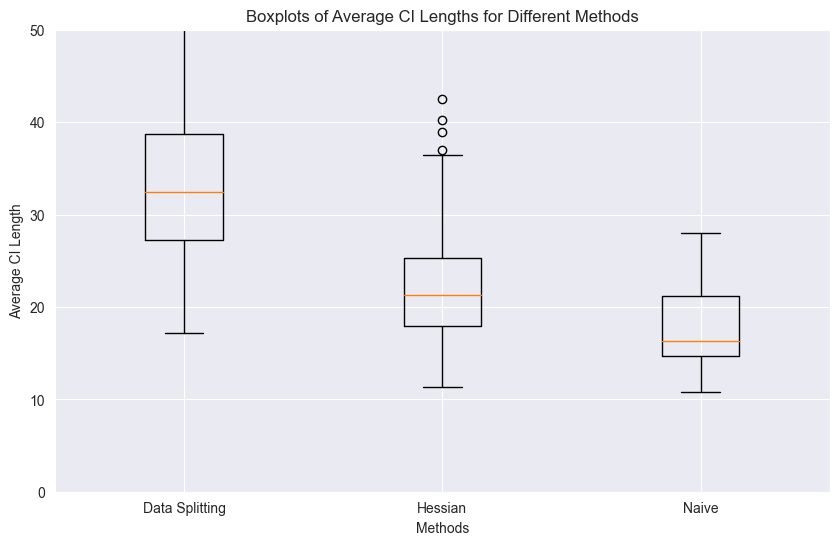

In [95]:
plot_boxplots(ci_lengths=results[1], 
                method_names=["Data Splitting", "Hessian", "Naive"])

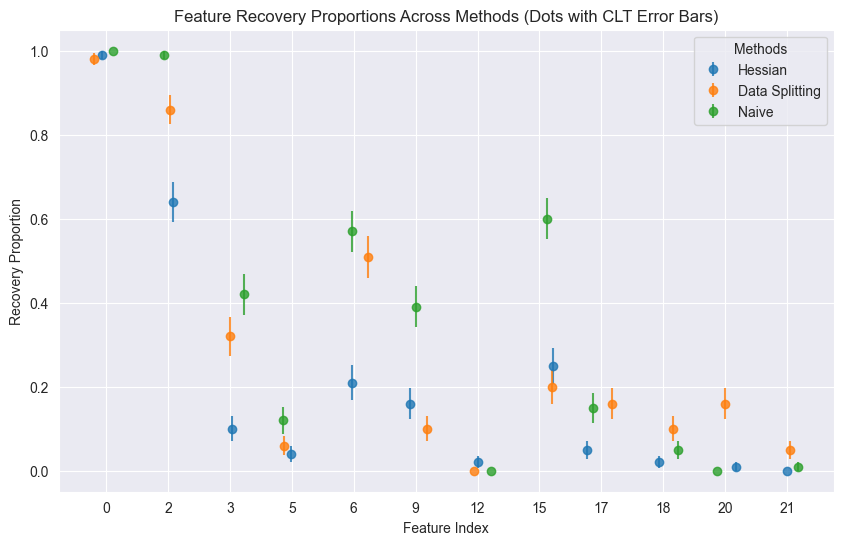

In [96]:
plot_recovery_dots_with_calculated_errorbars(recovery_dicts=results[0],
                       method_names=["Hessian", 
                                     "Data Splitting", "Naive"],
                       feature_indices=conv_full._ordered_groups,
                                             n_simulations=100)